# Part I - Initial Transit Parameters

Import libraries

In [2]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import triangle

import scipy as sp
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10,8  # Default image size for this interactive session

import astroML 
from astroML.stats import mean_sigma 
from astroML.time_series import search_frequencies, lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap, MultiTermFit 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=True)

Properties of the star and the planet candidate. Planet properties provided by R. Sanchis 

In [4]:
depth = 0.15*0.01 # (In absolute terms)
period = 19.306566 # (In days)
ecc = 0.0
b = 0.5

t0 = 1919.57971 # (-2454900) 
Rp = 3.47 
Mp = 31.87

#Star properties (from http://arxiv.org/pdf/1503.07866v1.pdf)
mass = 0.93
masserr = (0.05+0.06)/2.0
radius = 0.93
radiuserr = (0.05+0.06)/2.0
Teff = 5553

# From Claret (From Roberto's USPmass program)
u1 = 0.44 
u2 = 0.24
diffLD = u1-u2

# Kepler cadence
tKep = 29.42/(60.0*24.0)

allfixed = [period, ecc,  mass, masserr, radius, radiuserr, diffLD, tKep]

Upload the photometric data and plot the raw LC.

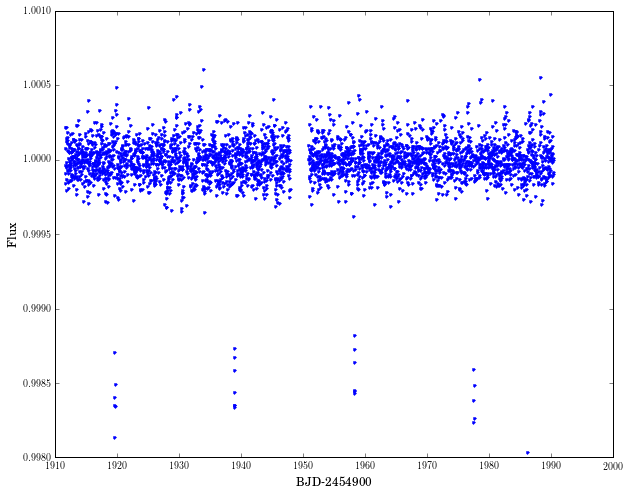

In [5]:
import glob, os
os.chdir("/Users/mariona/Desktop/summer2015")
for file in glob.glob("LCfluxesepic*.txt"):
    data = pd.read_table(file, sep='\s+', header = None, names=['time', 'flux','other'])
    timeLC = data['time']
    fluxLC = data['flux']
    errorLC = np.std(fluxLC)
    meanFlux = np.mean(fluxLC)
    goodP = fluxLC<=meanFlux+3*errorLC
    plt.figure(1)
    plt.plot(timeLC[goodP], fluxLC[goodP],'.')
    plt.xlabel('BJD-2454900', fontsize=12)
    plt.ylabel('Flux', fontsize=12)

In [6]:
minTime = min(timeLC) 
maxTime = max(timeLC)

def my_range(start, end, step):
    while start <= end:
        yield start
        start += step
        
minepoch = -10
maxepoch = 20
numepochs = maxepoch-minepoch+1

transitLoc = np.empty(numepochs)

for x in my_range(minepoch, maxepoch, 1):
    transit = t0+x*period
    transitLoc[x-minepoch]=transit
    
goodTrans = (transitLoc<=maxTime) & (transitLoc>=minTime) # Returns boolean
transits = transitLoc[goodTrans] # Stores transit times

Print the estimated transit times and mark them with vertical red lines on the LC.

[ 1919.57971   1938.886276  1958.192842  1977.499408]


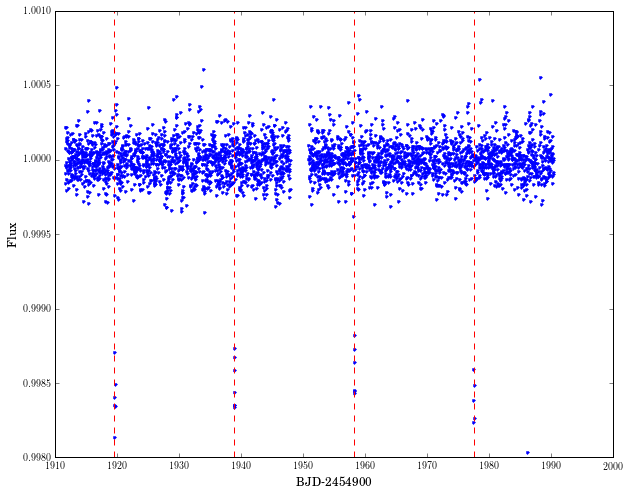

In [8]:
print transits
num_transits = len(transits)
plt.figure(2)
plt.plot(timeLC[goodP], fluxLC[goodP],'.')
plt.xlabel('BJD-2454900', fontsize=12)
plt.ylabel('Flux', fontsize=12)
for i in range(0,num_transits):
    plt.axvline(transits[i],color='r',ls='dashed')

Select the points that are "transit_window" hours to the left and to the right of the transit.

In [9]:
t=timeLC[goodP]
f=fluxLC[goodP]
transit_window = 8.0 #In hours
window = transit_window/24 # In days

sumPoints=0

for i in range(0,len(transits)):
   selPoints=np.abs(t - transits[i])<=window
   sumPoints=np.sum(selPoints)+sumPoints

#print sumPoints #Cantidad total de puntos en los 4 tránsitos en la franja que nos interesa

timeTrans = np.empty(sumPoints)
fluxTrans = np.empty(sumPoints)
flag = np.empty(sumPoints)
midTrans = np.empty(sumPoints)

sumPoints = 0
for i in range(0,len(transits)):
   selPoints=np.abs(t - transits[i])<=window
   numPoints = np.sum(selPoints)
   timeTrans[0+sumPoints:numPoints+sumPoints] = t[selPoints]
   fluxTrans[0+sumPoints:numPoints+sumPoints] = f[selPoints]
   flag[0+sumPoints:numPoints+sumPoints] = i
   midTrans[0+sumPoints:numPoints+sumPoints] = transits[i] 
   sumPoints = numPoints + sumPoints 

Plot the folded light curve.

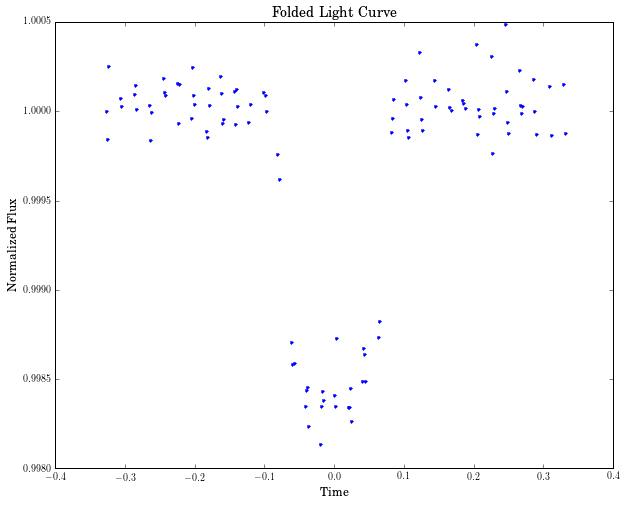

In [10]:
dt = timeTrans-midTrans
plt.plot(dt, fluxTrans,'.')
plt.title('Folded Light Curve', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Normalized Flux', fontsize=12)

From the figure shown above, we can visually estimate the range of the transit. For this star, it's approximately +-0.1

In [11]:
rangeTransit = 0.1
dataBool = np.abs(dt)>=rangeTransit # If true, point is outside of the transit.
out = (timeTrans<=rangeTransit) & (timeTrans>=rangeTransit) # This is a boolean array that tells you which points are outside of the transit.

Plot each transit. Optional: Save the figure. 

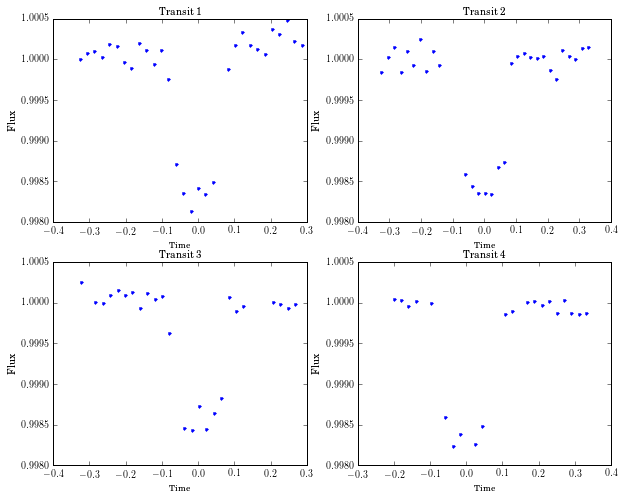

In [14]:
plt.figure(3)
for i in range(0,len(transits)):
    transitBool=(flag==i) # np.abs(dt)>=rangeTransit
    plt.subplot(2,2,i+1)
    plt.plot(dt[transitBool],fluxTrans[transitBool],'.')
    plt.xlabel('Time',fontsize=9)
    plt.ylabel('Flux',fontsize=10)
    plt.title('Transit %d' % (i+1)) 
#plt.savefig("Individual transits.png")

For each transit, apply a linear fit to the regions outside the transit. Optional: Store the figure. 

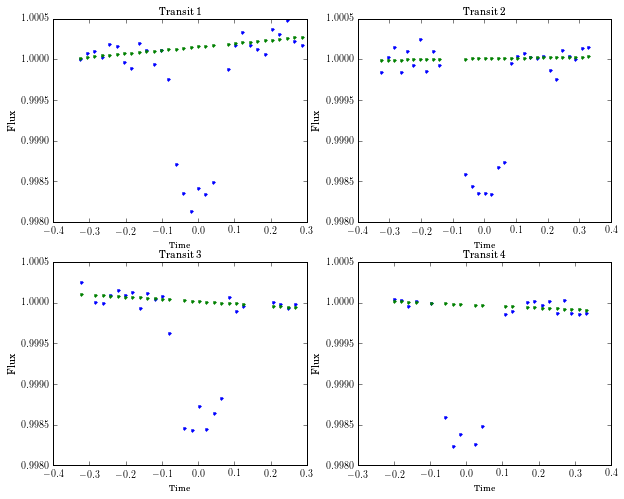

In [15]:
plt.figure(4)
for i in range(0,len(transits)):
    transitBool=(flag==i)
    outsideBool=(np.abs(dt)>=rangeTransit) & (flag==i)
    plt.subplot(2,2,i+1)
    z=np.polyfit((dt[outsideBool]), fluxTrans[outsideBool], 1)
    p=np.poly1d(z)
    plt.plot(dt[transitBool],fluxTrans[transitBool],'.')
    plt.plot(dt[transitBool],p(dt[transitBool]),'.')
    plt.xlabel('Time',fontsize=9)
    plt.ylabel('Flux',fontsize=10)
    plt.title('Transit %d' % (i+1)) 
#plt.savefig("FitOutsideTransits.png")

Divide the "light curve" of each transit by the fit obtained in the previous window. Optional: Plot the results.

In [16]:
#plt.figure(5)
corFlux=fluxTrans
for i in range(0,len(transits)):
    transitBool=(flag==i)
    outsideBool=(np.abs(dt)>=rangeTransit) & (flag==i)
    #plt.subplot(2,2,i+1)
    z=np.polyfit((dt[outsideBool]), fluxTrans[outsideBool], 1)
    p=np.poly1d(z)
    #plt.plot(dt[transitBool],fluxTrans[transitBool],'.')
    #plt.plot(dt[transitBool],fluxTrans[transitBool]/p(dt[transitBool]),'.')
    #plt.xlabel('Time')
    #plt.ylabel('Flux')
    #plt.show()
    corFlux[transitBool]=fluxTrans[transitBool]/p(dt[transitBool])

Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    
1. theta[0] = pdepth = (Rp/Rs)^2
2. theta[1] = pb = the impact parameter 
3. theta[2] = pt0 = the time of transit
4. theta[3] = sigma = an additional white noise term
5. theta[4] = u1 + u2 = sum of LD coefficients
6. theta[5] = pmass = the mass of the star (controlled via gaussian prior)
7. theta[6] = pradius = the radius of the star (controlled via gaussian prior)
8. theta[7] = f0 = the out of eclipse flux

In [17]:
import transit
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):

    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    
    period, ecc, mass, masserr, radius, radiuserr, diffLD, tKep = allfixed 
    
    u1 = 0.5*(sumLD+diffLD) 
    u2 = sumLD-u1
   
    # We'll use the "transit" library to generate an artificial light curve with the parameters that we know and
    # with those we want to fit. The first step is to use the"transit.System(transit.Central()))" module to create a 
    # planetary 'system' with a 'central' bright star and a number N (>=0) of bodies in orbit. The default orbits of
    # such celestial objects are 100% Keplerian unless another type is specified. The parameters used to model the
    # 'central' star are the LD coefficients (mu1, mu2), its mass (pmass), and its radius (pradius). 

    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass=pmass,radius=pradius))
    
    # Second step: With the "transit.Body" library, we define the properties of our planet in the system. The input 
    # parameters are the radius of the planet (r=Rp: this is calculated by taking the sqrt of pdepth -- obtaining 
    # Rp/Rs --, and then multiplying by the radius of the star (pradius, which corresponds to Rs) to obtain Rp), its 
    # period (given in the previous window), the time at which the transit occurs (t0 = pt0), the absolute value of 
    # the impact parameter, and the eccentricity (which we have also defined in the previous window.) 
   
    body = transit.Body(r=np.sqrt(pdepth)*pradius, period=period, t0=pt0, b=np.abs(pb), e=ecc)
    
    # Third step: Add the planet to the system s. 
    s.add_body(body)
    
    # Fourth step
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    
    # Fifth step: Now that the star and the orbiting planet have been characterized, we can create a theoretical 
    # light curve (ftheo). To achieve this goal, the input parameters we need are: the times where the light curve 
    # should be evaluated in days (timeLC), the time of exposure (texp = tKep), the "stopping criterion for the 
    # exposure time integration" (t01=10^-8), and the"maximum depth of the exposure time integrator" (maxdepth).
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    
    # Sixth Step: We subtract 1 and add the out of eclipse flux (f0) to our theoretical light curve.  
    ftheo = ftheo-1+f0
    
    # Seventh Step: Returns probability of the theoretical model to be the right model given the parameters that
    # characterize the star and the planet in our system.
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)

In [18]:
def lnprior(theta):
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    if (0.4 < sumLD < 1.0) and (0 <= pb <0.9) and (0 <= sigma) and (pradius>0) and (pdepth>0):
        return 0.0
    return -np.inf

In [19]:
def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

In [20]:
nll = lambda *args: -lnprob(*args)

# Minimization of the function nll
result = op.minimize(nll, [1.2*depth, b, 0.0, 0.0, 0.6, mass, radius, 1.0], 
                     args=(dt, fluxTrans, errorLC, allfixed), options={'disp': True}, method='Nelder-Mead')

# Best guesses for each parameter, stored in "result"
depth_ml, b_ml,  t0_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml  = result["x"]

# Readjust LD coefficients. 
u1_ml = 0.5*(sumLD_ml + diffLD)
u2_ml = sumLD_ml-u1_ml

Optimization terminated successfully.
         Current function value: -873.208007
         Iterations: 664
         Function evaluations: 1003


Compute each transit LC integrated over a Kepler long cadence exposure time with the result derived from optimization. Then, plot it.

In [21]:
s = transit.System(transit.Central(mu1=u1_ml, mu2=u2_ml, mass = mass_ml, radius = radius_ml ))
body = transit.Body(r=np.sqrt(depth_ml)*radius_ml, period=period, t0=t0_ml, b=b_ml, e=ecc)
s.add_body(body)

t_theory = np.arange(-1, 1, tKep*0.01)
f_theory = s.light_curve(t_theory, texp=tKep, tol=1e-08, maxdepth=4)
f_theory = f_theory-1.0 + f0_ml

Plot of the theoretical and the observed data on the same graph

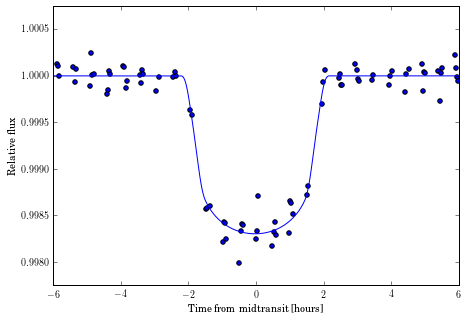

In [22]:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1,2,1)
ax.scatter(24.0*dt,fluxTrans)
plt.xlim([-6.0, 6.0]) 
plt.ylim([1-depth*1.5, depth*0.5+1]) 
ax.set_xlabel('Time from midtransit [hours]')
ax.set_ylabel('Relative flux')
ax.plot(24.0*t_theory, f_theory)

Print the best guesses.

In [23]:
depth_ml, b_ml,  t0_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml

(0.0015669276217474255,
 0.62688198679744078,
 -0.0012663132066092605,
 4.0382821939991208e-11,
 0.62054242543638494,
 0.92718951248481241,
 0.94091569399602548,
 1.0000012139894519)

With the best fit solutions, we'll run an MCMC routine to estimate the uncertainties on the parameters.

In [24]:
ndim, nwalkers = 8, 20
pos = [result["x"]*(1+1e-4*np.random.randn(ndim)) for i in range(nwalkers)]

In [26]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(dt, fluxTrans, errorLC, allfixed))
st = 1000 #st = Number of steps
sampler.run_mcmc(pos, st)

(array([[  1.47935423e-03,   5.51257261e-01,  -1.97043470e-03,
           7.05474678e-11,   9.04869267e-01,   9.23181059e-01,
           9.06492098e-01,   1.00001243e+00],
        [  1.56074058e-03,   6.09619697e-01,  -4.39300726e-03,
           2.05822827e-09,   5.20546228e-01,   9.10535410e-01,
           8.63390498e-01,   9.99965420e-01],
        [  1.32326827e-03,   3.83370189e-01,  -2.32631303e-03,
           2.32758644e-10,   5.53806607e-01,   9.47629864e-01,
           7.82214003e-01,   9.99960816e-01],
        [  1.53539475e-03,   3.16739525e-01,  -1.28319666e-04,
           1.34952873e-10,   4.12968791e-01,   1.10551349e+00,
           8.03915496e-01,   1.00000631e+00],
        [  1.60915551e-03,   6.38755304e-01,  -7.23427592e-04,
           2.02008221e-09,   6.08912811e-01,   9.49209881e-01,
           9.54753175e-01,   1.00001564e+00],
        [  1.37574257e-03,   2.58704005e-01,   6.02301451e-04,
           1.72581729e-09,   8.36066597e-01,   8.49770197e-01,
           7.4

In [28]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

We will now plot the results in a triangle plot. Explanation of a corner plot (from http://dan.iel.fm/emcee/current/user/line/): It shows "all the 1D and 2D projections of the posterior probability distributions of your parameters. This is useful because it quickly demonstrates all of the covariances between parameters. Also, the way that you find the marginalized distribution for a parameter or set of parameters using the results of the MCMC chain is to project the samples into that plane and then make an N-dimensional histogram. That means that the corner plot shows the marginalized distribution for each parameter independently in the histograms along the diagonal, and then the marginalized two dimensional distributions in the other panels."

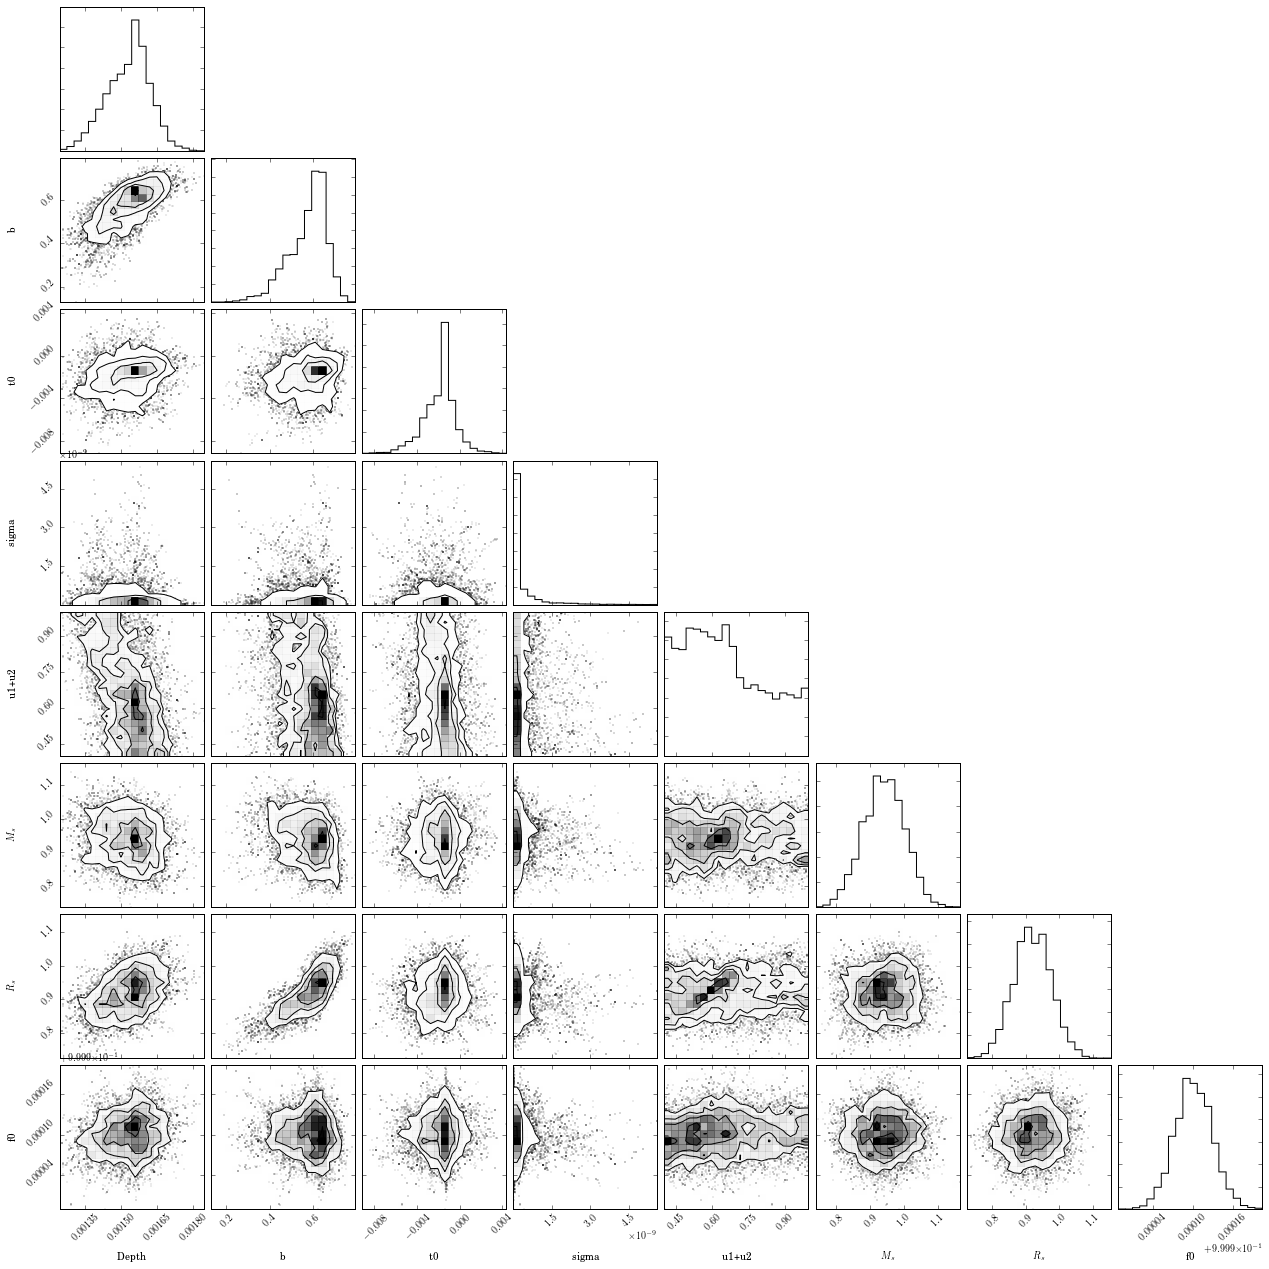

In [30]:
import triangle
fig = triangle.corner(samples, labels=["Depth", "b", "t0", "sigma", "u1+u2", "$M_s$", "$R_s$", "f0"]) 
#fig.savefig("triangle.png")

Calculates the uncertainties based on the 16, 50th, and 84th percentiles of the samples in the marginalized distributions.

In [31]:
planetradsamp = 109.045*np.sqrt(samples[:,0])*samples[:, 6]

G = 6.6730e-11
P1 = period*24.0*3600.0
r_asamp = ((3.0*np.pi/(G*P1**2))*((samples[:,6]**3/samples[:, 5])/1408.0))**0.3333

depth_mcmc, b_mcmc,  t0_mcmc, sigma_mcmc, sumLD_mcmc, mass_mcmc, radius_mcmc, f0_mcmc = map(lambda v: 
                            (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [15.84, 50, 84.16], axis=0)))


v = np.percentile(planetradsamp, [16, 50, 84], axis=0)
planetrad_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

v = np.percentile(r_asamp, [16, 50, 84], axis=0)
r_a_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

The planet radius in units of the Earth's radius and its +- errors.

In [32]:
planetrad_mcmc

(3.9375329601072622, 0.28962750396665538, 0.33136285668880738)

The inverse of the scaled semi-major axis is:

In [40]:
r_a_mcmc

(0.031072203800279596, 0.0019230983134699182, 0.0019966142326219884)

In [41]:
np.savetxt('PartI_finalparameters.txt', (depth_mcmc, b_mcmc,  t0_mcmc, sigma_mcmc, sumLD_mcmc, mass_mcmc,
                                    radius_mcmc, f0_mcmc, planetrad_mcmc,r_a_mcmc), fmt='%.4e', delimiter='   ',
            header = """Parameters obtained from a fit to the Kepler data. The first column represents the 50% percentile
            of the MCMC posterior distribution, whereas the second (third) represents the +1 (-1) sigma uncertainty. In row 
            order, the parameters are: Depth, Impact parameter, time of transit, sigma (additional white noise), Sum of LD coefficients, 
            Mass of the star, Radius of the star (gaussian priors on both), out of eclipse flux, Planet radius, R_s/a.""") 